In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import networkx as nx

from node2vec import Node2Vec

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.optimize import  linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from seirsplus.networks import generate_demographic_contact_network, household_country_data

N = 500

demographic_graphs, individual_ageGroups, households = generate_demographic_contact_network(
    N=N, 
    demographic_data=household_country_data('US'),
    distancing_scales=[0.7], 
    isolation_groups=[]
)

G = demographic_graphs['baseline']

Generated overall age distribution:
0-9: 0.1140	(-0.0070 from target)
10-19: 0.1360	(0.0050 from target)
20-29: 0.1560	(0.0190 from target)
30-39: 0.1340	(0.0010 from target)
40-49: 0.1600	(0.0360 from target)
50-59: 0.0980	(-0.0330 from target)
60-69: 0.1020	(-0.0130 from target)
70-79: 0.0620	(-0.0080 from target)
80+: 0.0380	(0.0000 from target)

Generated household size distribution:
1: 0.3077	(0.0240 from target)
2: 0.3317	(-0.0134 from target)
3: 0.1346	(-0.0161 from target)
4: 0.1394	(0.0118 from target)
5: 0.0529	(-0.0049 from target)
6: 0.0288	(0.0062 from target)
7: 0.0048	(-0.0077 from target)
Num households: 208
mean household size: 2.448393594

Generating graph for 0-9...
Generating graph for 10-19...


/opt/anaconda3/lib/python3.9/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)


Generating graph for 20-59...
Generating graph for 60+...


In [3]:
from seirsplus.assignment import embed_nodes, get_equal_sized_clusters

In [4]:
G = nx.relabel_nodes(G, {i: "node_" + str(i) for i in G.nodes()})
embedding, model = embed_nodes(graph=G, dimensions=32)
clusters = get_equal_sized_clusters(embedding, model=model, graph=G, cluster_size=N / 5) # 2m 11.6s

Computing transition probabilities:   0%|          | 0/500 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 18.72it/s]


In [6]:
from collections import Counter

In [7]:
Counter(clusters.values())

Counter({1: 100, 0: 100, 2: 100, 3: 100, 4: 100})

In [8]:
color_dict = {0: 'green', 1: 'blue', 2: 'red', 3: 'pink', 4: 'cyan'}

In [9]:
color_map = [color_dict[clusters[i]] for i in G.nodes()]

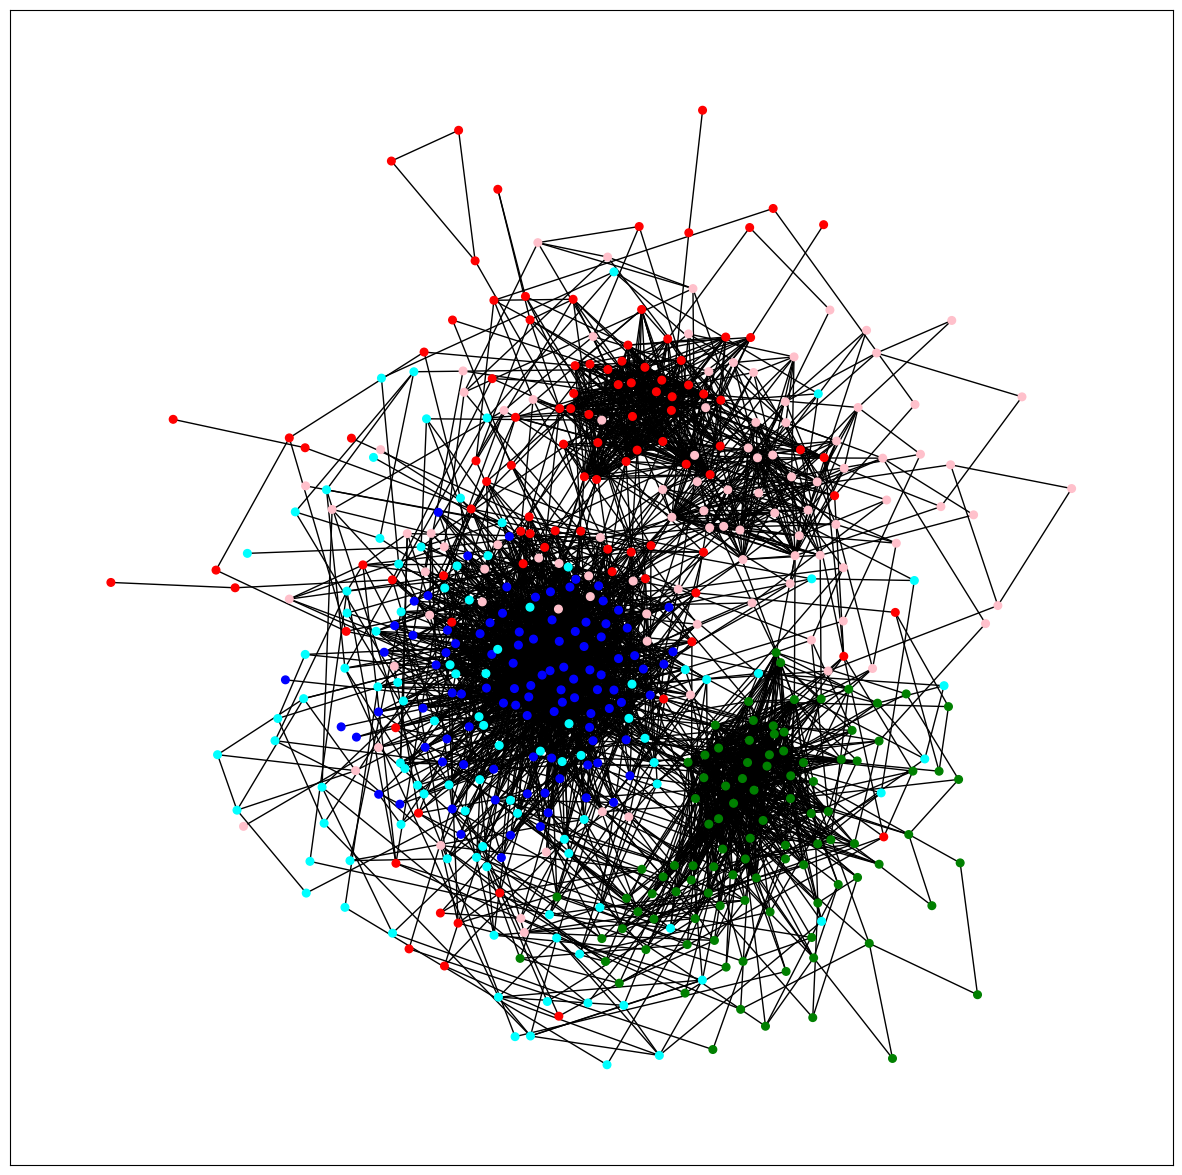

In [10]:
fig, ax = plt.subplots(figsize=(15, 15))
nx.draw_networkx(G, node_color=color_map, pos=nx.kamada_kawai_layout(G), with_labels=False, node_size=30, ax=ax)


In [11]:
groups = {i: [x for x,v in clusters.items() if v == i] for i in range(5)}

### Option 1: Use original embedding

In [12]:
group_0 = {i: model.wv.key_to_index[i] for i in G.subgraph(groups[0]).nodes()}
sorted_group_0 = sorted(group_0.items(), key=lambda x:x[1])
sorted_group_0 = dict(sorted_group_0)
key_to_index = {x: idx for idx, x in enumerate(sorted_group_0)}

In [13]:
clusters_group_0_orig = get_equal_sized_clusters(
    embedding[list(sorted_group_0.values()), :],
    model=model,
    graph=G.subgraph(groups[0]),
    cluster_size=5,
    key_to_index=key_to_index,
)

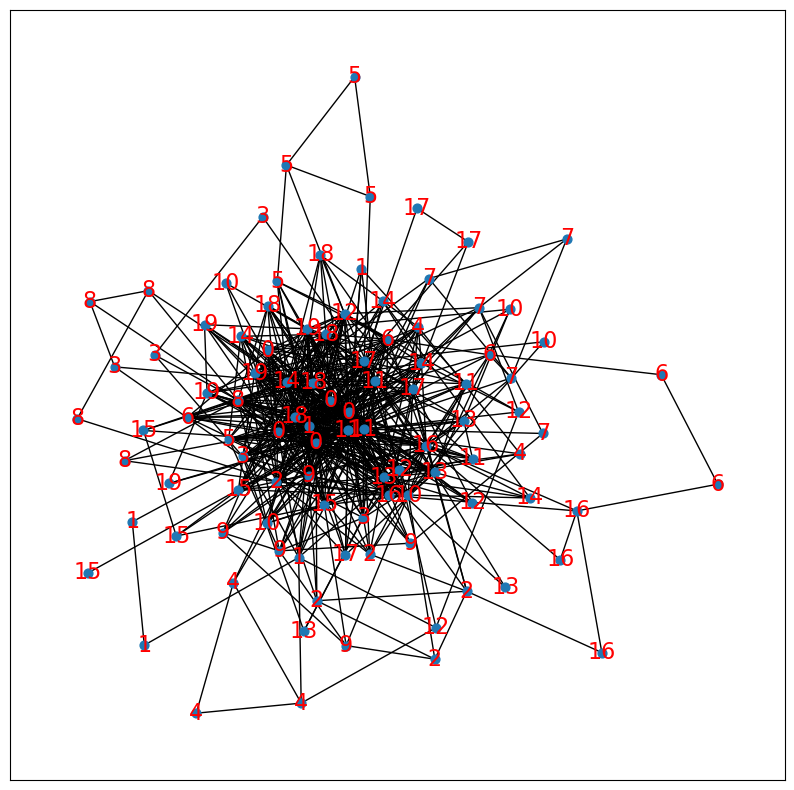

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

nx.draw_networkx(
    G.subgraph(groups[0]),
    pos=nx.kamada_kawai_layout(G.subgraph(groups[0]), scale=4), 
    with_labels=False, 
    node_size=40, 
    ax=ax
)
nx.draw_networkx_labels(
    G.subgraph(groups[0]),
    pos=nx.kamada_kawai_layout(G.subgraph(groups[0]), scale=4),
    labels=clusters_group_0_orig, 
    font_size=16,
    font_color='r'
)

plt.show()

### Option 2: Re-calculate the embedding on subgraph

In [15]:
graph_0 = G.subgraph(groups[0])
embedding_group_0, model_group_0 = embed_nodes(graph=graph_0, dimensions=64)
clusters_group_0 = get_equal_sized_clusters(embedding_group_0, model=model_group_0, graph=graph_0, cluster_size=5)

Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 129.79it/s]


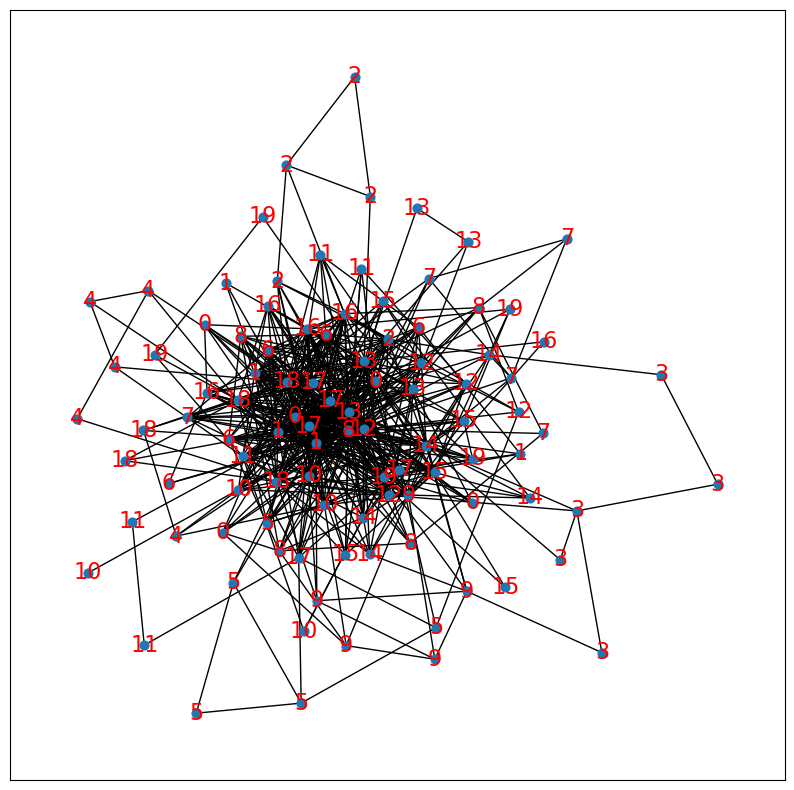

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

nx.draw_networkx(
    graph_0,
    pos=nx.kamada_kawai_layout(graph_0, scale=4), 
    with_labels=False, 
    node_size=40, 
    ax=ax
)
nx.draw_networkx_labels(
    graph_0,
    pos=nx.kamada_kawai_layout(graph_0, scale=4),
    labels=clusters_group_0, 
    font_size=16,
    font_color='r'
)

plt.show()

### Test on a large network

In [9]:
import time
start = time.time()
N = 10000

demographic_graphs, individual_ageGroups, households = generate_demographic_contact_network(
    N=N, 
    demographic_data=household_country_data('US'),
    distancing_scales=[0.7], 
    isolation_groups=[]
)

G = demographic_graphs['baseline']

print(f"Generating the graph takes {time.time() - start} seconds.")

Generated overall age distribution:
0-9: 0.1107	(-0.0103 from target)
10-19: 0.1226	(-0.0084 from target)
20-29: 0.1384	(0.0014 from target)
30-39: 0.1374	(0.0044 from target)
40-49: 0.1269	(0.0029 from target)
50-59: 0.1309	(-0.0001 from target)
60-69: 0.1192	(0.0042 from target)
70-79: 0.0783	(0.0083 from target)
80+: 0.0356	(-0.0024 from target)

Generated household size distribution:
1: 0.2872	(0.0035 from target)
2: 0.3340	(-0.0111 from target)
3: 0.1469	(-0.0038 from target)
4: 0.1348	(0.0071 from target)
5: 0.0545	(-0.0033 from target)
6: 0.0282	(0.0056 from target)
7: 0.0144	(0.0019 from target)
Num households: 4036
mean household size: 2.448393594

Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...
Generating the graph takes 12.873608112335205 seconds.


In [10]:
start = time.time()

G = nx.relabel_nodes(G, {i: "node_" + str(i) for i in G.nodes()})
embedding, model = embed_nodes(graph=G, dimensions=32)
clusters = get_equal_sized_clusters(embedding, model=model, graph=G, cluster_size=N / 5) 

print(f"Assigning testing groups takes {time.time() - start} seconds.")

Computing transition probabilities:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Assigning testing groups takes 119.30748295783997 seconds.


In [11]:
start = time.time()

groups = {i: [x for x,v in clusters.items() if v == i] for i in range(5)}
group_0 = {i: model.wv.key_to_index[i] for i in G.subgraph(groups[0]).nodes()}
graph_0 = G.subgraph(groups[0])
embedding_group_0, model_group_0 = embed_nodes(graph=graph_0, dimensions=32)
clusters_group_0 = get_equal_sized_clusters(embedding_group_0, model=model_group_0, graph=graph_0, cluster_size=5)

print(f"Assigning testing pools for one testing group takes {time.time() - start} seconds.")

Computing transition probabilities:   0%|          | 0/2000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


Assigning testing pools for one testing group takes 10.018484115600586 seconds.
